#Importación de Librerías

In [ ]:
# Verificamos el tiempo de inicio del código para un cálculo al final
# ==============================================================================
import time
start_time = time.time()


# Importación de librerías utilizadas

# Tratamiento de datos
# ==============================================================================

import pandas as pd     # Importamos Pandas
import numpy as np


# Gráficos
# ==============================================================================

from tabulate import tabulate       # Importamos tabulate
import matplotlib.pyplot as plt       # Importamos pyplot de matplotlib

# Preprocesado y modelado
# ==============================================================================

# Preprocesado
from sklearn.decomposition import PCA     # PCA de .descomposition
from sklearn.preprocessing import LabelEncoder      # LabelEncoder de .preprocessing
from sklearn.model_selection import train_test_split      # train_test_split de model_selection

# Modelado
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier # RandomForestClassifier y GradientBoostingClassifier de .ensemble

# Métricas
# ==============================================================================

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report # Sacamos las métricas a medir de .metrics

# Configuración warnings
# ==============================================================================

import warnings
warnings.filterwarnings('ignore') # Ignoramos los warnings innecesarios

#Dataset y su procesamiento

In [ ]:
# Traemos el dataset desde Github y le asignamos la variable "df"
# ==============================================================================
url = "https://raw.githubusercontent.com/LAUGOD/Videogames-Dataset/main/video_games_sales.csv"
df = pd.read_csv (url)

In [ ]:
# Verificamos tamaño y tipo de las columnas
# ==============================================================================
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16719 entries, 0 to 16718
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16717 non-null  object 
 1   Platform         16719 non-null  object 
 2   Year_of_Release  16450 non-null  float64
 3   Genre            16717 non-null  object 
 4   Publisher        16665 non-null  object 
 5   NA_Sales         16719 non-null  float64
 6   EU_Sales         16719 non-null  float64
 7   JP_Sales         16719 non-null  float64
 8   Other_Sales      16719 non-null  float64
 9   Global_Sales     16719 non-null  float64
 10  Critic_Score     8137 non-null   float64
 11  Critic_Count     8137 non-null   float64
 12  User_Score       10015 non-null  object 
 13  User_Count       7590 non-null   float64
 14  Developer        10096 non-null  object 
 15  Rating           9950 non-null   object 
dtypes: float64(9), object(7)
memory usage: 2.0+ MB


In [ ]:
# Manipulación de datos

# Eliminamos las columnas que no manipularemos
# ==============================================================================
col_del = ["Developer", "User_Count", "User_Score", "Critic_Score", "Critic_Count"] # Se eliminan por exceso de nulos
df = df.drop(labels=col_del, axis=1)

# Buscamos rellenar los valores de "Rating" con cálculos de moda
# ==============================================================================
# Agrupamos "Genre" y "Publisher", y calculamos la moda de "Rating"
mode_rating_by_genre_publisher = df.groupby(['Genre', 'Publisher'])['Rating'].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None)

# Calculamos la moda de "Rating" basada en "Genre"
mode_rating_by_genre = df.groupby('Genre')['Rating'].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None)

# Llenamos "Rating" en base a los resultados obtenidos
def impute_rating(row):
    genre = row['Genre']
    publisher = row['Publisher']
    if pd.isnull(genre):
        return row['Rating']
    else:
        mode_rating = mode_rating_by_genre_publisher.get((genre, publisher), None)
        if mode_rating is not None:
            return mode_rating
        else:
            # Si no hay una moda específica para Genre-Publisher, usamos la moda de Genre
            return mode_rating_by_genre.get(genre, row['Rating'])

# Aplicamos los datos encontrados
df['Rating'] = df.apply(impute_rating, axis=1)

# Quitamos nulos restantes
# ==============================================================================
df = df.dropna()

In [ ]:
# Variables Sintéticas

# Simplificamos "Platforms"
# ==============================================================================
# Categorizamos las plataformas en 3 sectores, para una más fácil comprensión de datos
df['Platform_Category'] = df['Platform'].apply(lambda platform: "PC" if platform == "PC" else ("Portable" if platform in ["DS", "PSP", "3DS", "PSV", "GB", "GBA"] else "Console"))

# Simplificamos "Global_Sales"
# ==============================================================================
# Calculamos el promedio de ventas globales
average_sales = df['Global_Sales'].mean()

# Definimos los umbrales basados en porcentajes
low_sales_treshold = 0.7 * average_sales  # 70% del promedio
high_sales_treshold = 1.3 * average_sales  # 130% del promedio

# Creaamos la variable "Sales_Category" con los umbrales basados en porcentajes
df['Sales_Category'] = pd.cut(df['Global_Sales'], bins=[-float('inf'), low_sales_treshold, high_sales_treshold, float('inf')],
                               labels=["Low Sales", "Moderated Sales", "High Sales"])

In [ ]:
# Verificamos el tamaño final del dataset
# ==============================================================================
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16416 entries, 0 to 16718
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Name               16416 non-null  object  
 1   Platform           16416 non-null  object  
 2   Year_of_Release    16416 non-null  float64 
 3   Genre              16416 non-null  object  
 4   Publisher          16416 non-null  object  
 5   NA_Sales           16416 non-null  float64 
 6   EU_Sales           16416 non-null  float64 
 7   JP_Sales           16416 non-null  float64 
 8   Other_Sales        16416 non-null  float64 
 9   Global_Sales       16416 non-null  float64 
 10  Rating             16416 non-null  object  
 11  Platform_Category  16416 non-null  object  
 12  Sales_Category     16416 non-null  category
dtypes: category(1), float64(6), object(6)
memory usage: 1.6+ MB


#Gráficos y Tablas

              Global_Sales   NA_Sales   EU_Sales   JP_Sales  Other_Sales
Genre                                                                   
Action           19.494927   9.796949   5.799719   1.817583     2.068191
Sports           14.872880   7.618096   4.214582   1.531451     1.500579
Shooter          11.824734   6.637800   3.569791   0.439017     1.172792
Role-Playing     10.565682   3.745942   2.136517   4.011532     0.674301
Platform          9.373482   5.044378   2.263069   1.483554     0.578962
Misc              8.889179   4.472000   2.367035   1.214673     0.828547
Racing            8.213856   4.050348   2.661340   0.642749     0.857036
Fighting          5.023835   2.502781   1.123647   0.990625     0.407123
Simulation        4.406283   2.050598   1.284476   0.722312     0.347195
Puzzle            2.727737   1.374821   0.565001   0.643316     0.139605
Adventure         2.647379   1.150773   0.716750   0.592695     0.185799
Strategy          1.960025   0.768279   0.507230   

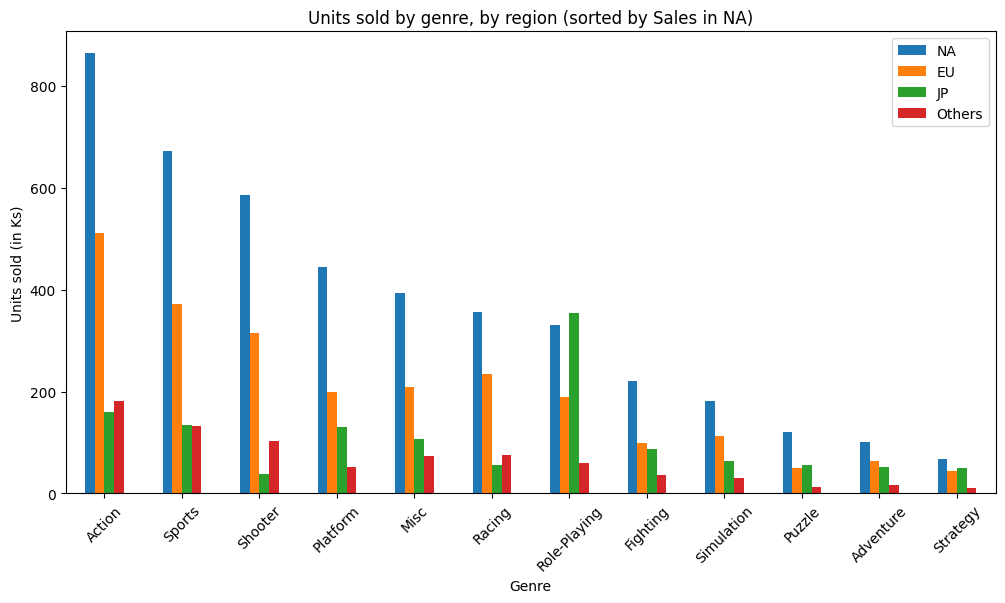

In [ ]:
# Gráficos y tablas

# Consumo de géneros por región (Tabla)
# ==============================================================================
# Se consigue el total de "Global_Sales"
total_global_sales = df['Global_Sales'].sum()

# Conseguimos el porcentaje de impacto de cada género, por región en base a "Global_Sales"
percentage_results = df.groupby('Genre').agg({
    'Global_Sales': lambda x: (x.sum() / total_global_sales) * 100,
    'NA_Sales': lambda x: (x.sum() / total_global_sales) * 100,
    'EU_Sales': lambda x: (x.sum() / total_global_sales) * 100,
    'JP_Sales': lambda x: (x.sum() / total_global_sales) * 100,
    'Other_Sales': lambda x: (x.sum() / total_global_sales) * 100
}).sort_values(by='Global_Sales', ascending=False)

# Agregamos una variable con los resultados de los porcentajes
total_percentage = percentage_results.sum()

# Creamos una fila "Total" y la colocamos dentro de "resultados_porcentaje", visualizando más fácilmente el impacto por región
percentage_results.loc['Total'] = total_percentage

# Imprimimos una tabla de porcentajes mostrando la influencia en el mercado de cada sector correspondiente a cada género
print(percentage_results)


# Consumo de géneros por región ordenados por "NA_Sales" (Gráfico)
# ==============================================================================
# Filtramos el DataFrame para incluir solo las columnas relevantes
sales_by_region_genre = df.groupby('Genre')[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']].sum()

# Ordenamos por ventas en la región de NA en orden descendente
sales_by_region_genre = sales_by_region_genre.sort_values(by='NA_Sales', ascending=False)

# Creamos un gráfico de barras no apiladas
sales_by_region_genre.plot(kind='bar', stacked=False, figsize=(12, 6))
plt.title('Units sold by genre, by region (sorted by Sales in NA)')
plt.ylabel('Units sold (in Ks)')
plt.xlabel('Genre')
plt.xticks(rotation=45)
plt.legend(["NA", "EU", "JP", "Others"])
plt.show()


Top 10 Global
╒════╤═══════════════════════════╤═══════════════════╤════════════╤══════════════╤════════════════╕
│    │ Name                      │   Year_of_Release │ Platform   │ Genre        │   Global_Sales │
╞════╪═══════════════════════════╪═══════════════════╪════════════╪══════════════╪════════════════╡
│  0 │ Wii Sports                │              2006 │ Wii        │ Sports       │          82.53 │
├────┼───────────────────────────┼───────────────────┼────────────┼──────────────┼────────────────┤
│  1 │ Super Mario Bros.         │              1985 │ NES        │ Platform     │          40.24 │
├────┼───────────────────────────┼───────────────────┼────────────┼──────────────┼────────────────┤
│  2 │ Mario Kart Wii            │              2008 │ Wii        │ Racing       │          35.52 │
├────┼───────────────────────────┼───────────────────┼────────────┼──────────────┼────────────────┤
│  3 │ Wii Sports Resort         │              2009 │ Wii        │ Sports       │   

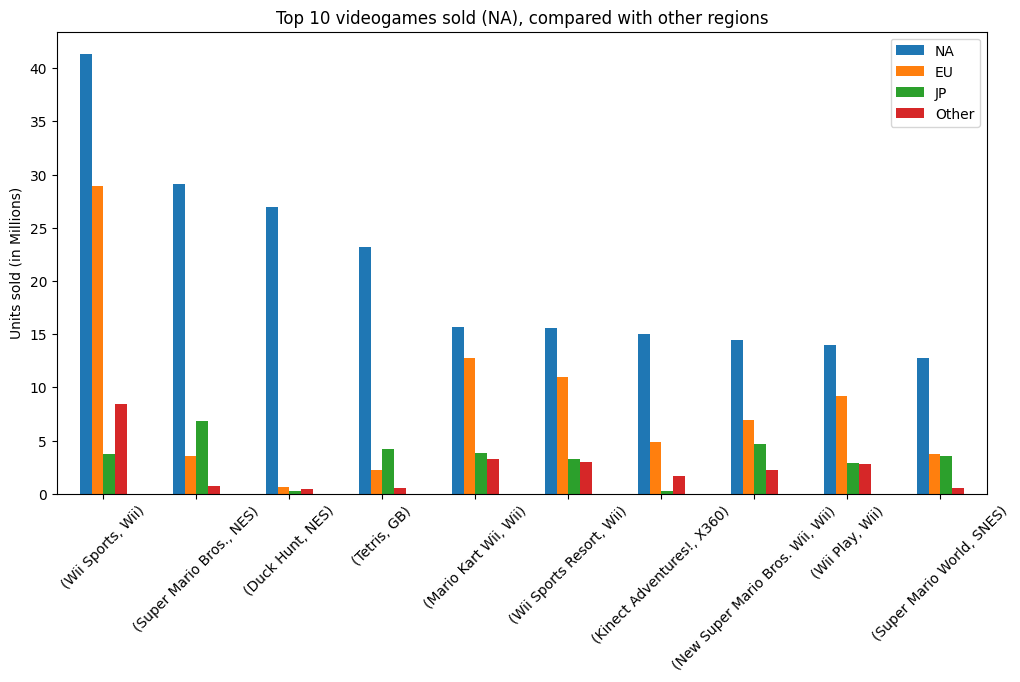

In [ ]:
# Top 10 videojuegos más vendidos por región (Tabla)
# ==============================================================================
# Top 10 Global
Global = df.nlargest(10, 'Global_Sales')[["Name", "Year_of_Release","Platform", "Genre", "Global_Sales"]]
print("\nTop 10 Global")
print(tabulate(Global, headers='keys', tablefmt='fancy_grid')) #En formato grilla para mayor claridad

# Top 10 NA
NA = df.nlargest(10, 'NA_Sales')[["Name", "Year_of_Release", "Platform", "Genre", "NA_Sales"]]
print("\nTop 10 NA")
print(tabulate(NA, headers='keys', tablefmt='fancy_grid'))

# Top 10 EU
EU = df.nlargest(10, 'EU_Sales')[["Name", "Year_of_Release", "Platform", "Genre", "EU_Sales"]]
print("\nTop 10 EU")
print(tabulate(EU, headers='keys', tablefmt='fancy_grid'))

# Top 10 JP
JP = df.nlargest(10, 'JP_Sales')[["Name", "Year_of_Release", "Platform", "Genre", "JP_Sales"]]
print("\nTop 10 JP")
print(tabulate(JP, headers='keys', tablefmt='fancy_grid'))

# Top 10 Other
Other = df.nlargest(10, 'Other_Sales')[["Name", "Year_of_Release",  "Platform", "Genre", "Other_Sales"]]
print("\nTop 10 Other")
print(tabulate(Other, headers='keys', tablefmt='fancy_grid'))

# Comparación Top 10 (NA) en otras regiones (Gráfico)
# ==============================================================================
# Filtramos para obtener columnas deseadas
top_na_compared = df.groupby(['Name', 'Platform'])[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']].sum()

# Ordenamos lo obtenido en "NA_Sales" por orden descendente
top_na_compared= top_na_compared.sort_values(by='NA_Sales', ascending=False)

# Obtenemos el top 10
top_10 = top_na_compared.head(10)

# Creamos un barplot vertical no apilado para ver la comparación de regiones
top_10.plot(kind='bar', stacked=False, figsize=(12, 6))
plt.title('Top 10 videogames sold (NA), compared with other regions')
plt.ylabel('Units sold (in Millions)')
plt.xlabel('')
plt.xticks(rotation=45)
plt.legend(["NA", "EU", "JP", "Other"])
plt.show()

#PCA

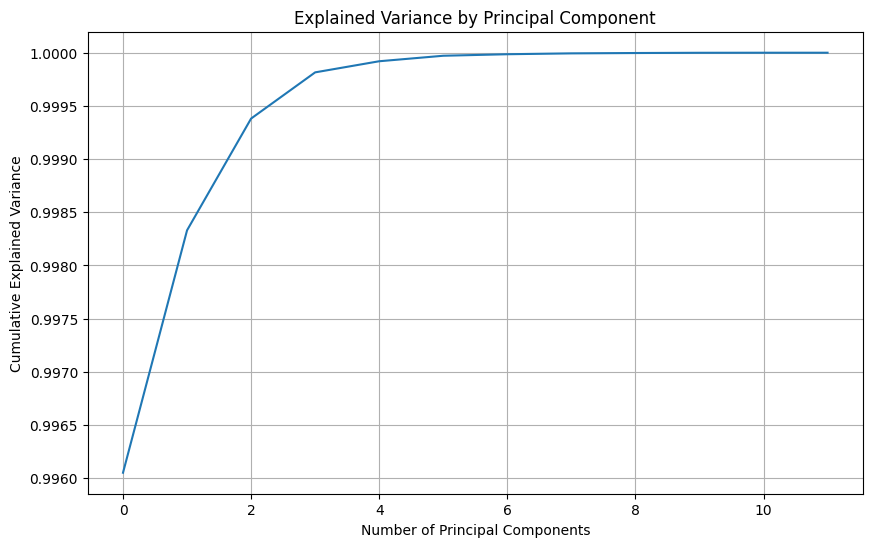

              Platform  Year_of_Release     Genre  Publisher  NA_Sales  \
Componente 1  0.000846        -0.001032  0.001113  -0.999998 -0.000021   
Componente 2 -0.974330        -0.217157 -0.001400  -0.000619 -0.002623   

              EU_Sales  JP_Sales  Other_Sales  Global_Sales    Rating  \
Componente 1 -0.000034 -0.000092    -0.000014     -0.000160  0.000424   
Componente 2 -0.002671  0.003744    -0.001312     -0.002855 -0.013922   

              Platform_Category  Sales_Category  Varianza Explicada  \
Componente 1          -0.000211       -0.000007            0.996052   
Componente 2           0.057358        0.000660            0.002279   

              Varianza Total Explicada  
Componente 1                  0.996052  
Componente 2                  0.998331  


In [ ]:
# PCA

# Verificamos el número de componentes necesario para explicar la mayor cantidad del dataset
# ==============================================================================
# Creamos un dataset aparte y excluimos la columna "Name"
X = df.drop(columns=['Name'])

# Realizamos LabelEncoding en todas las columnas categoricas restantes
label_encoder = LabelEncoder()
categorical_features = ['Platform', 'Publisher', 'Rating', 'Genre', "Sales_Category", "Platform_Category"]

for feature in categorical_features:
    X[feature] = label_encoder.fit_transform(X[feature])

# Ajustar PCA a tus datos
pca = PCA().fit(X)

# Crear un gráfico de la varianza explicada acumulada
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Principal Component')
plt.grid()
plt.show()

# Iniciamos PCA con el número de componentes óptimos (2 explican más del 99%)
# ==============================================================================
pca = PCA(n_components=2)

# Ajustamos PCA a los datos
X_reduced = pca.fit_transform(X)

# Obtenemos los componentes principales
components = pca.components_

# Creamos un DataFrame para mostrar las características y su impacto
component_names = [f'Componente {i+1}' for i in range(components.shape[0])]
explained_variance_ratio = pca.explained_variance_ratio_
explained_variance = pca.explained_variance_
loadings_df = pd.DataFrame(components, columns=X.columns, index=component_names)
loadings_df['Varianza Explicada'] = explained_variance_ratio
loadings_df['Varianza Total Explicada'] = explained_variance_ratio.cumsum()

# Mostramos las características y su impacto
print(loadings_df)

#Modelos de Clasificación (Machine Learning)

In [ ]:
# Modelos de Clasificación (Machine Learning)

# Clasificación "Genre"
# Excluir la columna "Name" y Genre del dataframe
X = df.drop(columns=['Name', 'Genre', "Platform"])
y = df["Genre"]

# Realiza Label Encoding en las características categóricas
label_encoder = LabelEncoder()
categorical_features = ['Publisher', 'Rating', "Platform_Category", "Sales_Category"]
for feature in categorical_features:
    X[feature] = label_encoder.fit_transform(X[feature])

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=49)

# Define una función para evaluar un modelo
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    confusion = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    return accuracy, precision, recall, f1, confusion, report

# Lista de modelos a evaluar
models = [
    ("Random Forest", RandomForestClassifier(min_samples_split=10, n_estimators=300)),
    ("Gradient Boosting", GradientBoostingClassifier(max_depth=5, n_estimators=200)),
]

# Evaluar y comparar los modelos
for name, model in models:
    accuracy, precision, recall, f1, confusion, report = evaluate_model(model, X_train, y_train, X_test, y_test)
    print(f"{name} - Metrics")
    print("==================================================================")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"f1: {f1:.2f}")
    print(f"Confusion Matrix:\n{confusion}")
    print(f"Classification Report:\n{report}")
    print("==================================================================")

Random Forest - Metrics
Accuracy: 0.51
Precision: 0.50
Recall: 0.51
f1: 0.49
Confusion Matrix:
[[458   9  17  22   9   4  12  53  32   4  14   4]
 [ 49 111   0  23   7   7  11   7  12   6  30   7]
 [ 42   1  60   3   0   0   0  41   5   1   3   1]
 [ 32  25   6 144  13  12  20  18   2  14  64   1]
 [ 37   8   7  12  57   6  11   7   1   3  24   1]
 [ 10   5   0  19   7  30  11   6   0   6  32   0]
 [ 24   6   3  16  21  13  81   3   0   4  80   1]
 [ 67   3  21  16   4   1   0 127  21   1  11  12]
 [ 67   1   7   8   0   2   0  10 171   2   0   1]
 [ 28  11   0  17   5  11  11  11   0  44  34   3]
 [  8  13   0  23   7  12  39   3   0   6 334   2]
 [ 30   5   7   7   3   2   3  17   8   7   6  46]]
Classification Report:
              precision    recall  f1-score   support

      Action       0.54      0.72      0.61       638
   Adventure       0.56      0.41      0.47       270
    Fighting       0.47      0.38      0.42       157
        Misc       0.46      0.41      0.44       35

In [ ]:
# Clasificación "Sales_Category"

# Excluir la columna "Name" y Genre del dataframe
X = df.drop(columns=['Name', 'Global_Sales', "NA_Sales", "EU_Sales", "JP_Sales", "Other_Sales", "Sales_Category"])
y = df["Sales_Category"]

# Realiza Label Encoding en las características categóricas
label_encoder = LabelEncoder()
categorical_features = ["Platform", 'Publisher', 'Rating', "Genre", "Platform_Category"]
for feature in categorical_features:
    X[feature] = label_encoder.fit_transform(X[feature])

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)

# Lista de modelos a evaluar
models = [
    ("Random Forest", RandomForestClassifier(max_depth=30, min_samples_leaf=4, n_estimators=300, random_state=50)),
    ("Gradient Boosting", GradientBoostingClassifier(max_depth=4, n_estimators=300, random_state=50)),
]

# Evaluar y comparar los modelos
for name, model in models:
    accuracy, precision, recall, f1, confusion, report = evaluate_model(model, X_train, y_train, X_test, y_test)
    print(f"{name} - Metrics")
    print("==================================================================")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"f1: {f1:.2f}")
    print(f"Confusion Matrix:\n{confusion}")
    print(f"Classification Report:\n{report}")
    print("==================================================================")

Random Forest - Metrics
Accuracy: 0.73
Precision: 0.66
Recall: 0.73
f1: 0.67
Confusion Matrix:
[[ 202  358   18]
 [  85 2168   20]
 [  71  348   14]]
Classification Report:
                 precision    recall  f1-score   support

     High Sales       0.56      0.35      0.43       578
      Low Sales       0.75      0.95      0.84      2273
Moderated Sales       0.27      0.03      0.06       433

       accuracy                           0.73      3284
      macro avg       0.53      0.45      0.44      3284
   weighted avg       0.66      0.73      0.67      3284

Gradient Boosting - Metrics
Accuracy: 0.73
Precision: 0.66
Recall: 0.73
f1: 0.67
Confusion Matrix:
[[ 232  328   18]
 [ 107 2142   24]
 [  76  343   14]]
Classification Report:
                 precision    recall  f1-score   support

     High Sales       0.56      0.40      0.47       578
      Low Sales       0.76      0.94      0.84      2273
Moderated Sales       0.25      0.03      0.06       433

       accuracy   

#Tiempo de procesamiento

In [ ]:
#Verifico el tiempo de finalización
end_time = time.time()

#Mido la diferencia entre tiempo de inicio y fin
total_time = end_time - start_time

#Imprimo el tiempo total que llevó hacer todo el código en un formato más legible
print(f"Tiempo total de ejecución: {total_time:.2f} segundos")

Tiempo total de ejecución: 114.07 segundos
